In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import math
import json
import ccxt

In [2]:
def convert_tz(utc):
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    utc = utc.replace(tzinfo=from_zone).astimezone(to_zone)
    
    return utc

In [3]:
def get_date_list(start_date, end_date=None):
    '''
    Generate list of date to fetch 1 day iteration from fetch_ohlcv.
    '''
    if end_date == None:
        end_date = dt.date.today()
    
    num_day = (end_date - start_date).days
    date_list = [dt.date.today() - dt.timedelta(days = x) for x in range(num_day, 0, -1)]
    
    return date_list

In [4]:
def get_js_date(dt_date):
    '''
    Transform dt.datetime to JavaScript format.
    '''
    dt_datetime = dt.datetime(dt_date.year, dt_date.month, dt_date.day)
    js_datetime = dt_datetime.timestamp() * 1000
    
    return js_datetime

In [5]:
def get_ohlcv(symbol, date_list, timeframe, limit):
    df = pd.DataFrame(columns = ['time', 'open', 'high', 'low', 'close', 'volume'])

    for i in range(len(date_list)):
        since = get_js_date(date_list[i])
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        df_temp = pd.DataFrame(ohlcv)
        df_temp.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        df_temp['time'] = pd.to_datetime(df_temp['time'], unit='ms')
        df_temp['time'] = df_temp['time'].apply(lambda x: convert_tz(x))

        df = pd.concat([df, df_temp])

    df = df.reset_index(drop=True)

    return df

In [6]:
def get_timeframe(period):
    timeframe_dict = {1440:'1d', 240:'4h', 60:'1h', 30:'30m', 15:'15m'}
    
    for i in timeframe_dict.keys():
        if period % i == 0:
            min_period = i
            break
            
    min_timeframe = timeframe_dict[min_period]
    step = int(period / min_period)
            
    return min_timeframe, step

In [7]:
def group_timeframe(df, step):
    h_dict = {'time':[], 'open':[], 'high':[], 'low':[], 'close':[]}
    
    mod = len(df) % step
    if  mod != 0:
        df = df.iloc[:-mod, :]
        
    for i in [x for x in range(0, len(df), step)]:
        df_temp = df.iloc[i:i + step, :]
        h_dict['time'].append(df_temp['time'][i])
        h_dict['open'].append(df_temp['open'][i])
        h_dict['high'].append(max(df_temp['high']))
        h_dict['low'].append(min(df_temp['low']))
        h_dict['close'].append(df_temp['close'][i + 1])

    df = pd.DataFrame(h_dict)
    
    return df

In [8]:
def get_signal(df, signal, interval):
    func_dict = {'tma': signal_tma}
    
    df = func_dict[signal](df, interval)
    
    return df

In [9]:
def signal_tma(df, interval):
    period = (interval + 1) / 2
    
    # trunc ma to get minimum avg steps
    df['ma'] = df['close'].rolling(window=math.trunc(period)).mean()
    
    # round tma to reach interval steps
    df['signal'] = df['ma'].rolling(window=int(np.round(period))).mean()
    
    df = df.drop(columns=['ma'])
    df = df.dropna().reset_index(drop=True)
    
    return df

In [10]:
def round_down_amount(amount, decimal):
    floor_amount = np.floor((amount * (10 ** decimal))) / (10 ** decimal)
    
    return floor_amount

### Config 

In [11]:
with open('../../../_keys/ftx/ftx_test_keys.json') as keys_file:
    keys_dict = json.load(keys_file)

In [12]:
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

In [13]:
base_currency = 'ETH'
quote_currency = 'USD'
decimal = 3

In [14]:
file_path = 'data'

In [15]:
signal = 'tma'
period = 120
interval = 50

In [16]:
start_date = dt.date(2019, 9, 16) # first available data
end_date = dt.date(2021, 7, 26)

### Get timeframe 

In [17]:
min_timeframe, step = get_timeframe(period)

In [18]:
limit = int(1440 / (period / step))

### Get data

In [19]:
symbol = '{}/{}'.format(base_currency, quote_currency)

In [20]:
date_list = get_date_list(start_date, end_date)

In [21]:
df_raw = get_ohlcv(symbol, date_list, min_timeframe, limit)

In [22]:
df_raw

,time,open,high,low,close,volume
0,2019-09-15 04:00:00+07:00,188.375,188.89,187.27,188.60,8.682133e+03
1,2019-09-15 05:00:00+07:00,188.600,188.84,187.67,187.84,0.000000e+00
2,2019-09-15 06:00:00+07:00,187.840,189.19,187.81,188.76,0.000000e+00
3,2019-09-15 07:00:00+07:00,188.760,190.86,188.71,188.88,0.000000e+00
4,2019-09-15 08:00:00+07:00,188.880,189.10,188.72,188.86,0.000000e+00
...,...,...,...,...,...,...
16288,2021-07-24 19:00:00+07:00,2156.200,2162.30,2146.90,2160.70,6.426838e+06
16289,2021-07-24 20:00:00+07:00,2160.700,2175.90,2154.50,2156.30,4.822655e+06
16290,2021-07-24 21:00:00+07:00,2156.300,2173.90,2146.10,2165.10,5.778713e+06
16291,2021-07-24 22:00:00+07:00,2165.100,2181.50,2152.00,2152.40,7.131236e+06


### Group timeframe

In [23]:
df = group_timeframe(df_raw, step)

In [24]:
df

,time,open,high,low,close
0,2019-09-15 04:00:00+07:00,188.375,188.89,187.27,187.84
1,2019-09-15 06:00:00+07:00,187.840,190.86,187.81,188.88
2,2019-09-15 08:00:00+07:00,188.880,189.10,187.95,187.96
3,2019-09-15 10:00:00+07:00,187.960,188.03,186.21,187.61
4,2019-09-15 12:00:00+07:00,187.610,188.46,187.45,188.18
...,...,...,...,...,...
8141,2021-07-24 13:00:00+07:00,2133.900,2146.40,2126.70,2133.50
8142,2021-07-24 15:00:00+07:00,2133.500,2144.00,2117.60,2142.20
8143,2021-07-24 17:00:00+07:00,2142.200,2169.70,2132.70,2156.20
8144,2021-07-24 19:00:00+07:00,2156.200,2175.90,2146.90,2156.30


### Get signal

In [25]:
df = get_signal(df, signal, interval)

In [26]:
df

,time,open,high,low,close,signal
0,2019-09-19 05:00:00+07:00,211.78,212.99,209.91,210.11,197.828077
1,2019-09-19 07:00:00+07:00,210.19,210.19,205.64,206.14,198.478523
2,2019-09-19 09:00:00+07:00,206.20,207.75,202.05,204.55,199.123938
3,2019-09-19 11:00:00+07:00,204.55,206.37,203.06,206.34,199.768846
4,2019-09-19 13:00:00+07:00,206.34,206.34,205.12,205.94,200.410954
...,...,...,...,...,...,...
8092,2021-07-24 13:00:00+07:00,2133.90,2146.40,2126.70,2133.50,1968.128154
8093,2021-07-24 15:00:00+07:00,2133.50,2144.00,2117.60,2142.20,1975.864000
8094,2021-07-24 17:00:00+07:00,2142.20,2169.70,2132.70,2156.20,1983.500000
8095,2021-07-24 19:00:00+07:00,2156.20,2175.90,2146.90,2156.30,1991.062154


### Run simulation 

In [27]:
df_simu = df.copy()

In [28]:
budget = 100
last_action_price = 0
last_action_amount = 0

In [29]:
signal_dict = {'action':[], 'action_price':[], 'budget':[], 'profit':[], 'drawdown':[]}

for i in range(len(df_simu)):
    if df['close'][i] > df['signal'][i]:
        action = 'buy'
    elif df['close'][i] < df['signal'][i]:
        action = 'sell'
    else:
        action = signal_dict['action'][-1]
    
    if i > 0:
        if action != signal_dict['action'][-1]:
            if last_action_price > 0:
                if action == 'buy':
                    profit = (last_action_price - df['close'][i]) * last_action_amount
                elif action == 'sell':
                    profit = (df['close'][i] - last_action_price) * last_action_amount

            last_action_price = df['close'][i]
            last_action_amount = round_down_amount(budget / last_action_price, decimal)
            
            budget += profit
        else:
            profit = 0
    else:
        profit = 0
        
    
    if last_action_price > 0:
        if action == 'buy':
            drawdown = (df['low'][i] - last_action_price) / last_action_price
        elif action == 'sell':
            drawdown = (last_action_price - df['high'][i]) / last_action_price
    else:
        drawdown = 0
        max_drawdown = 0
        
    signal_dict['action'].append(action)
    signal_dict['action_price'].append(last_action_price)
    signal_dict['budget'].append(budget)
    signal_dict['profit'].append(profit)
    signal_dict['drawdown'].append(drawdown)

In [30]:
budget

3417.163689999999

In [31]:
for s in signal_dict.keys():
    df_simu[s] = signal_dict[s]

In [32]:
df_simu.to_csv('simulation.csv', index=False)

### Viz 

In [33]:
import matplotlib.pyplot as plt

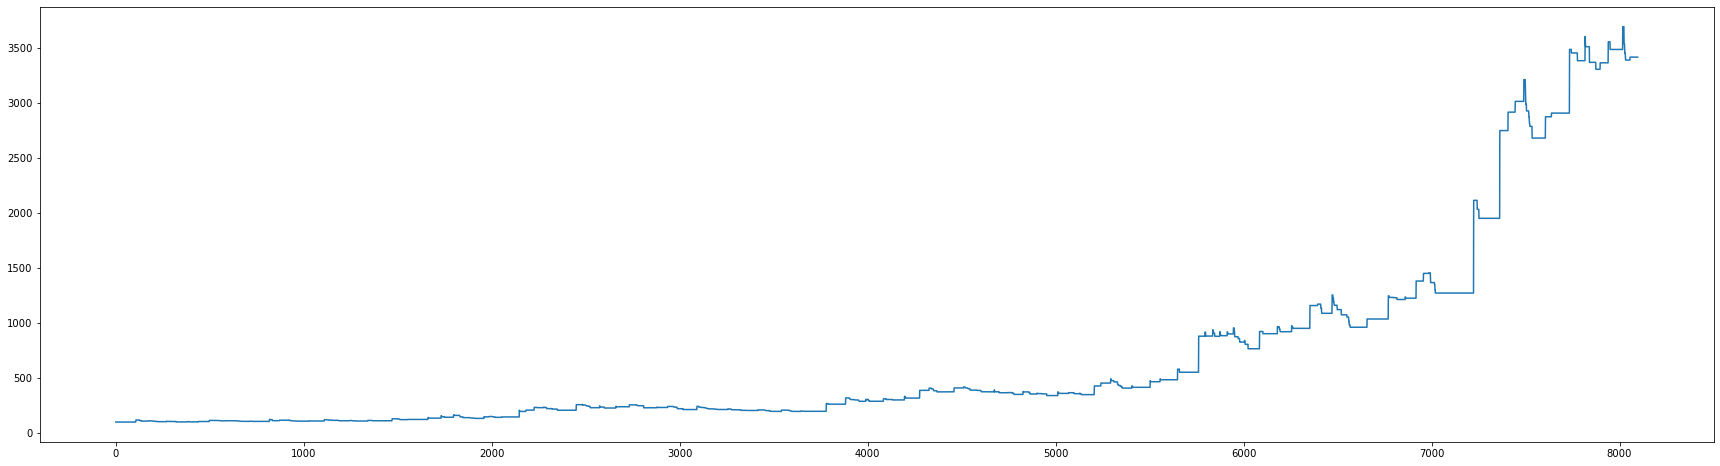

In [34]:
fig, ax = plt.subplots(figsize=(30, 8))
ax.plot(df_simu['budget'])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          0.,   0.,   1.,   2.,   4.,   0.,   0.,   1.,   0.,   1.,   1.,
          3.,   3.,   1.,   3.,   6.,   1.,   4.,   2.,   1.,   2.,   1.,
          5.,   4.,   2.,   6.,   4.,   6.,  10.,   3.,   8.,   7.,  10.,
         14.,  14.,  21.,  17.,  16.,  32.,  30.,  21.,  27.,  25.,  37.,
         57.,  41.,  61.,  42.,  70.,  65.,  72.,  84., 103., 100., 130.,
        120., 112., 137., 155., 139., 162.,  91.,  90.,  91.,  95., 111.,
         73.,  90.,  69.,  80.,  71.,  90.,  69.,  84.,  84.,  71.,  72.,
         73.,  53.,  66.,  47.,  62.,  59.,  73.,  54.,  72.,  63.,  51.,
         55.,  54.,  52.,  59.,  57., 

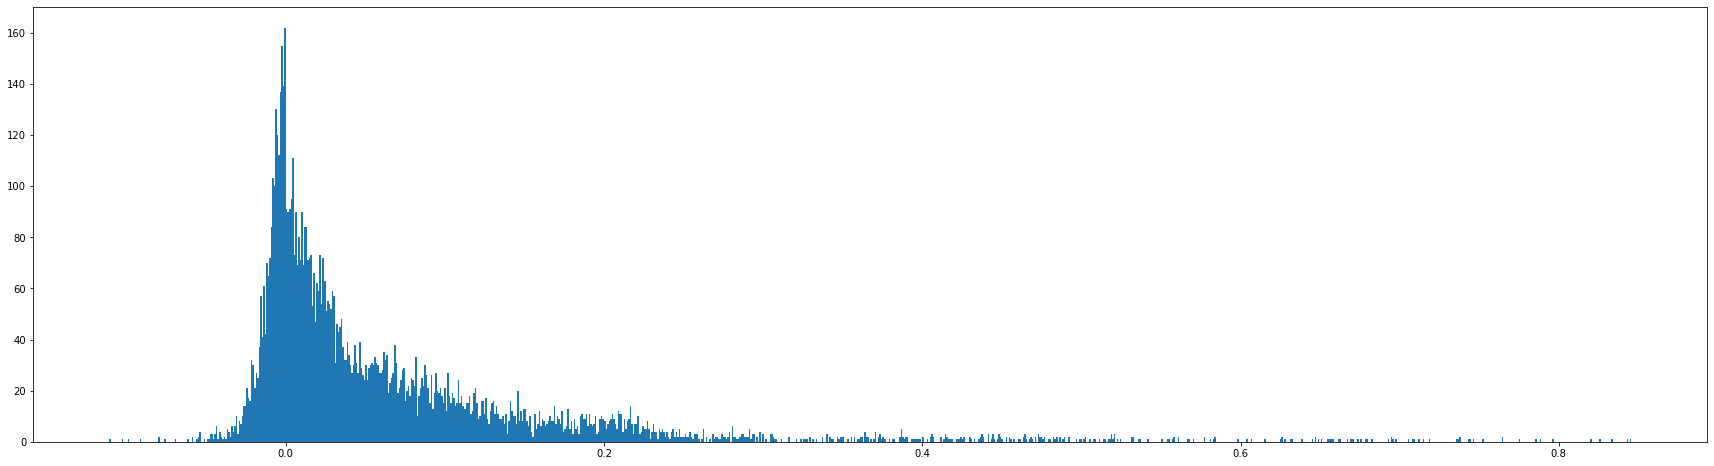

In [35]:
fig, ax = plt.subplots(figsize=(30,8))
ax.hist(df_simu['drawdown'], bins=1000)

In [36]:
df_simu['drawdown'].describe()

count    8097.000000
mean        0.065680
std         0.109108
min        -0.110873
25%         0.000126
50%         0.026354
75%         0.089917
max         0.845498
Name: drawdown, dtype: float64